### 🫁 Denoising Diffusion Medical Model (DDMM) for Acute Lymphoblastic Leukemia Dignosis 🫁

In [ ]:
from SRC.GoogleAuth import GoogleDriveConnector
from SRC.PreProcessing import PreProcessing
from SRC.ForwardDiffusion import ForwardDiffusion
from SRC.BackwardDiffusion import BackwardDiffusion

#### 🤔 Pre-Processing
Google drive authentication was utilized to access the train and test datasets for ALL. 
1. Creation of Google Developers Console Project, wherin GDrive API was enabled
2. Validate OAuth permissions and download `credentials.json` file

This dataset was originally from Kaggle. These include a collection of peripheral blood smear images for lumphoblasts (Early Pre-B, Pre-B, and Pro-B).

Then, the `matplotlib` was used to plot the images through an effective for-loop.It was declared to have 20 images and will continue looping until the index reaches that count.

In [1]:
# Connect to the google drive to access dataset
connectorObj = GoogleDriveConnector(credentials.json)
connectorObj.mount_drive()

Mounted at /content/google_drive


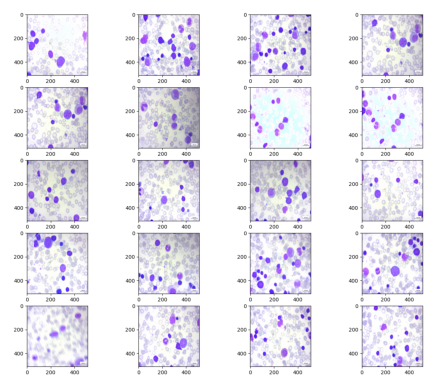

In [3]:
import torch 
import torchvision 
import matplotlib.pyplot as plt 
from torchvision import transforms 

#1. Define the root for training data 
train_root = "/content/google_drive/My Drive/UWaterloo Engineering/Co-Op/Co-Op_Term 2/ML Proj 3/BLL_Data/train"
data = torchvision.datasets.ImageFolder(
        root=train_root, 
        transform=transforms.Compose([
                      transforms.Resize((512,512)),
                      transforms.ToTensor()
        ])
)

# Call the show images function by creating an object
preProcessingObj = PreProcessing()
preProcessingObj.revealImagesGrid(data, 20, 4)

# Show the grid
plt.show()




#### ⏩ Forward Propagation of Diffusion 
Initially, it was decided that we'll be adding a specific amount of noise, beta in each timestep. To keep track of how much of the image we're keeping, this will be taken care of alpha which is 1-beta. Then, the calculations are done for cummulative amount of alpha on the current timestep without having to refer back to any previous scenarios. 

1. Variances are FIXED according to the noise level initially given
2. Linearly add noise to the image and compute the noise in current timestep

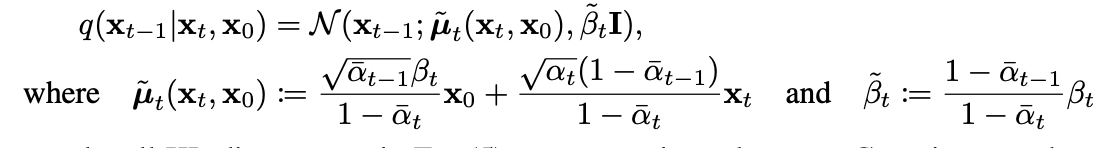

In [4]:
from torch.utils.data import DataLoader
# Create an instance of the forward diffusion class
forwardDiffusionInst = ForwardDiffusion(500, 0.00001, 0.4, 300)
train_root = "/content/google_drive/My Drive/UWaterloo Engineering/Co-Op/Co-Op_Term 2/ML Proj 3/BLL_Data/train"
test_root = "/content/google_drive/My Drive/UWaterloo Engineering/Co-Op/Co-Op_Term 2/ML Proj 3/BLL_Data/test"

# Call the forward diffusion 
data = forwardDiffusionInst.loadTransformedDataset(train_root, test_root)

# data loader
dataLoader = DataLoader(data, batch_size=30)

<ipython-input-26-f4853fe96c6f>:11: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed 
plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


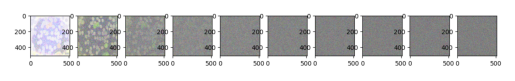

In [5]:
# Get the first image from the dataloader
startingImage = iter(dataLoader).next()[0]

# Set the number of images to display and the step size for timesteps
imageToDisplay = 10
timestep_step = 50

# Create a figure for displaying the images
fig, axs = plt.subplots(1, imageToDisplay+1, figsize=(15, 15))
plt.axis('off')

# Loop over the timesteps and display the images
for i in range(0, 500, timestep_step):
    # Convert the timestep to a tensor
    timestep_tensor = torch.tensor([i]).int()

    # Generate a noisy image for this timestep
    noisy_image, _ = forwardDiffusionInst.forwardDiffusionEngine(startingImage, timestep_tensor)

    # Display the noisy image
    axs[i // timestep_step].imshow(noisy_image.permute(1, 2, 0))


#### 🤖 Backward Propagation Process (UNet)
Incorporated concepts within the UNet, which has a very similar architecture to VAEs. This was done using positional embeddings, sequential layer stacks of group normalizations and conv2d, as well as upsampling and downsampling. This is crucial for computing the gradients and updating them using residual connection. This means that the upsampling will also contain the tensor data that the initial downsampling had previously. 
1. Compatible for denoising score matching indexed at the particular time step
2. Prevent loss in backward step

In [7]:
backwardDiffusionInst = BackwardDiffusion()
backwardDiffusionInst.forward()

Num params:  62433123
SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

Epoch 0 | step 000 Loss: 0.168717998086695 


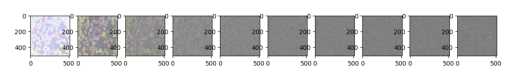

Epoch 0 | step 030 Loss: 0.1776979807696970 


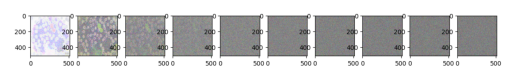

Epoch 1 | step 060 Loss: 0.2098797666869 


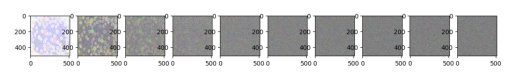

Epoch 2 | step 090 Loss: 0.168080877668696 


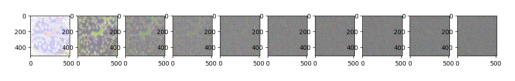

Epoch 3 | step 000 Loss: 0.128807779700 


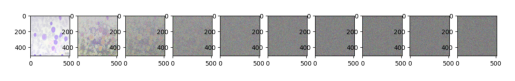

In [9]:
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backwardDiffusionInst.to(device)
optimizer = Adam(backwardDiffusionInst.parameters(), lr=0.001)
epochs = 100  

for epoch in range(epochs):
    for step, batch in enumerate(dataLoader):
        optimizer.zero_grad()

        timesteps = torch.randint(0, 500, (30,), device=device).long()
        inputs = batch[0].to(device)
        
        # Forward pass
        outputs = backwardDiffusionInst(inputs, timesteps)
        
        # Compute loss
        loss = torch.mean((outputs - inputs) ** 2)  # Example loss function
        
        # Backward pass and optimization step
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
            
            # Plot sample denoised images
            backwardDiffusionInst.eval()
            with torch.no_grad():
                for _ in range(10):
                    index = torch.randint(0, len(inputs), (1,))
                    input_image = inputs[index]
                    timestep = timesteps[index]
                    output_image = backwardDiffusionInst(input_image.unsqueeze(0), timestep.unsqueeze(0))
                    plt.figure(figsize=(4, 4))
                    plt.imshow(output_image.squeeze().cpu().detach().permute(1, 2, 0))
                    plt.show()
            backwardDiffusionInst.train()
